# Total Correation with Iterative Gaussianization

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# logging
import tqdm

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Toy Data

In [14]:
import sys, os
pysim_root = "/home/emmanuel/code/pysim"
sys.path.append(str(pysim_root))

In [58]:
from pysim.data.information.gaussian import (
    generate_gaussian_data,
    generate_gaussian_rotation_data,
)
from pysim.data.information.linear import generate_linear_entropy_data
from pysim.data.information.studentt import generate_studentt_data
from pysim.information.entropy import marginal_entropy
from pysim.information.histogram import hist_entropy

from typing import NamedTuple


def get_tc_datasets(n_samples, n_features, seed, dataset="gaussian", **kwargs):

    if dataset == "gaussian":

        res = generate_gaussian_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
        )

    elif dataset == "gaussian_rotation":

        res = generate_gaussian_rotation_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
        )

    elif dataset == "linear_rotation":

        f = partial(marginal_entropy, estimator=hist_entropy, bins="sqrt")

        res = generate_linear_entropy_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            marg_h_estimator=f,
            estimator_name="histogram",
            n_base_samples=500_000,
        )
    elif dataset == "studentt":

        res = generate_studentt_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
            df=kwargs.get("df", 3.0),
        )

    elif dataset == "cauchy":

        res = generate_studentt_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
            df=1.0,
        )

    else:
        raise ValueError(f"Unrecognized dataset.")

    return res

In [71]:
# generate data
res_tuple = get_tc_datasets(
    n_samples=100_000,
    n_features=30,
    seed=123,
    dataset="linear_rotation",
)

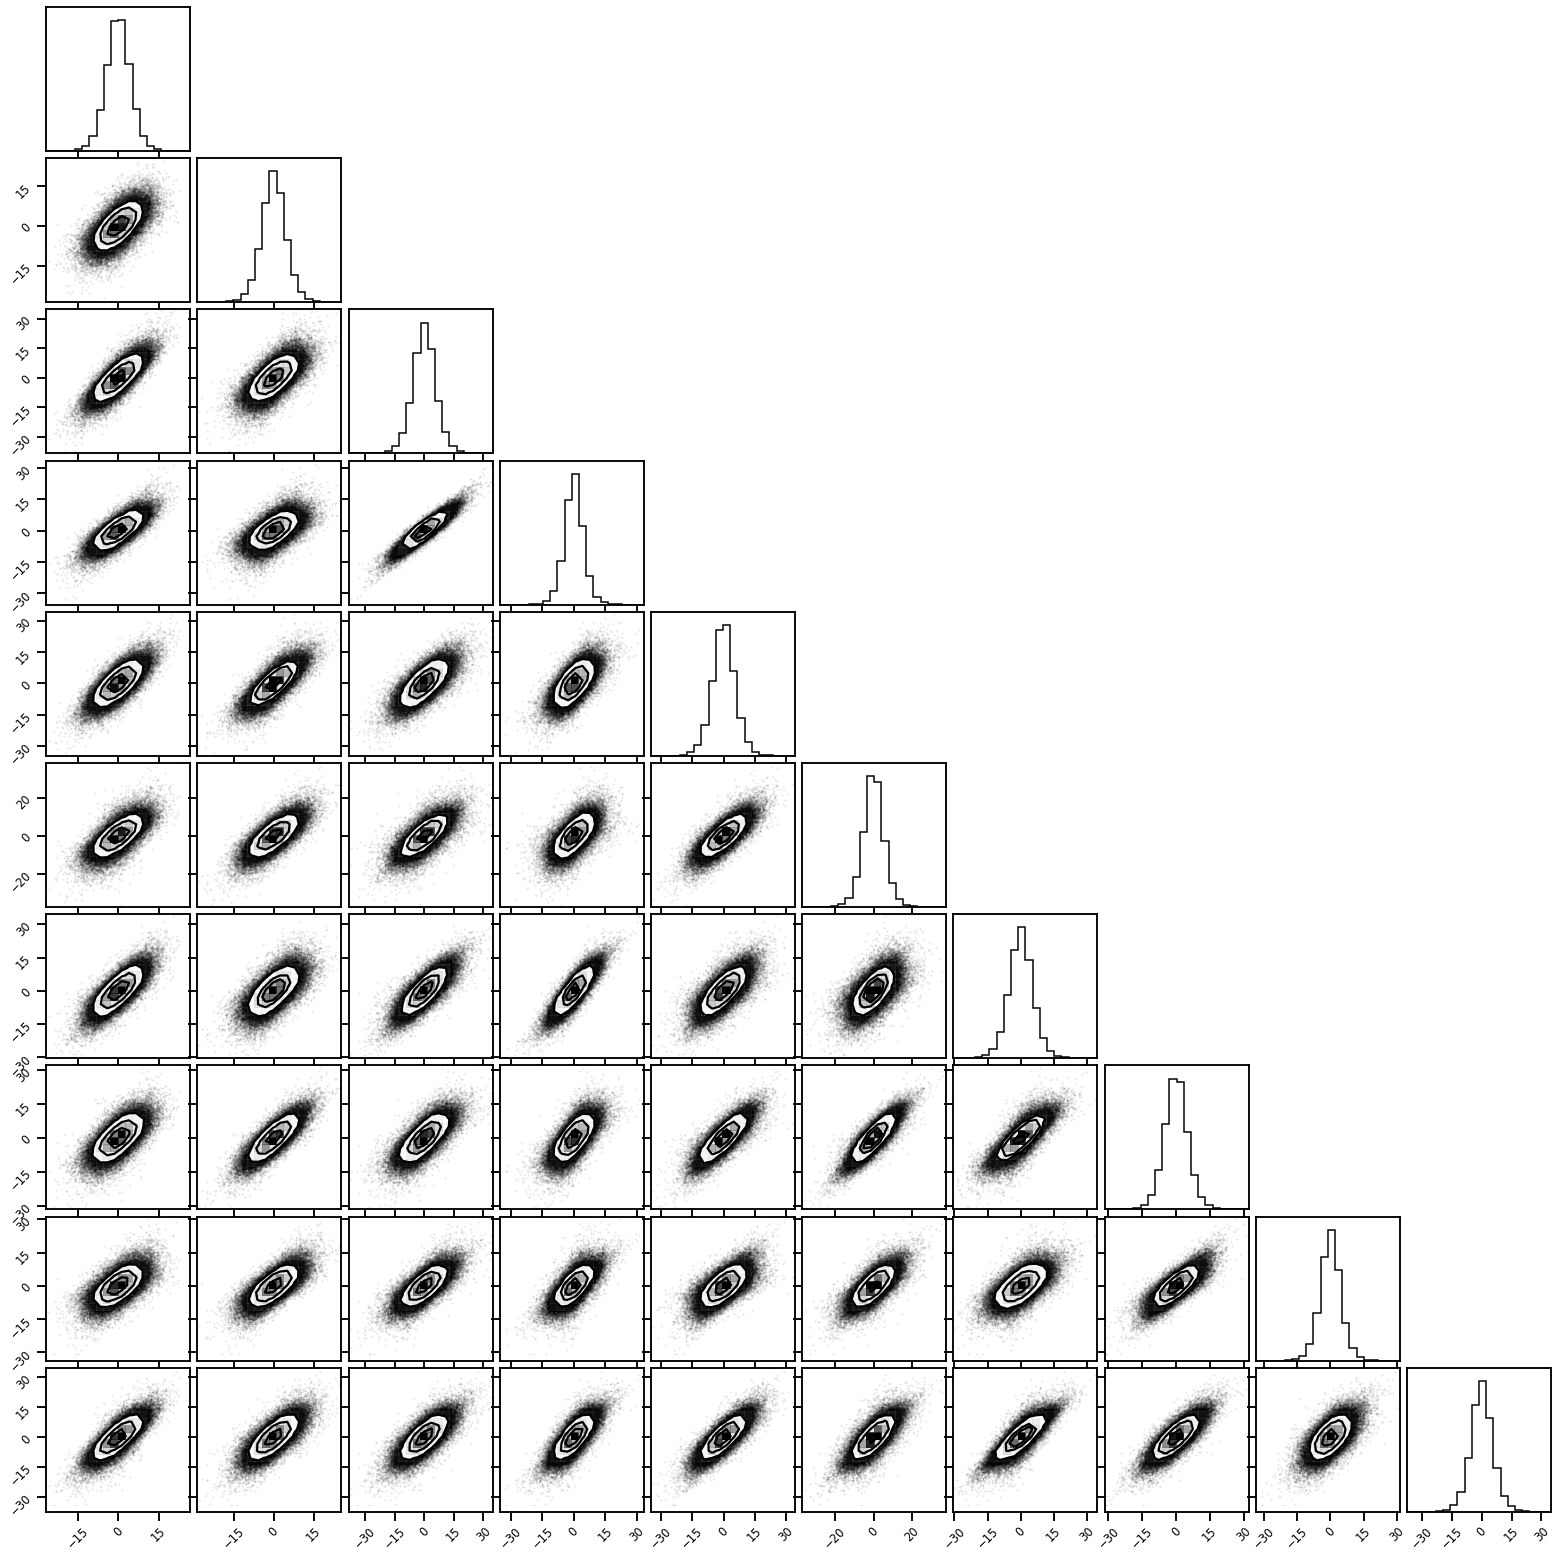

In [72]:
fig = corner.corner(res_tuple.X[:, :10], hist_factor=2)

### RBIG Approximation

In [66]:
from rbig_jax.models import RBIG
import jax.numpy as jnp

def default_rbig_params(data):
    
    X = jnp.array(data, dtype=np.float64)
    
    params = {
        "X": X,
        # marginal PDF params
        "support_extension": 20, 
        "precision": 100, 
        "eps": 1e-5, 
        "method": "histogram", 
        # Histogram specific params
        "nbins": int(jnp.sqrt(X.shape[0])),
        "alpha": 1e-5,
        # KDE specific params
        "bw": "scott",
        # info reduction loss parameters
        "max_layers" : 250,
        "zero_tolerance" : 10,
        "p" : 0.25,
        # training loop params
        "verbose" : True,
        "n_layers_remove" : 50,
        "interval" : 10,
        # everything (makes it fast...)
        "jitted" : True,
    }

    
    return params

In [73]:
X_g, rbig_model = RBIG(
    **default_rbig_params(res_tuple.X)
)

Layer 10 - Cum. Info Reduction: 35.711 - Elapsed Time: 16.4652 secs
Layer 20 - Cum. Info Reduction: 36.053 - Elapsed Time: 27.3335 secs
Layer 30 - Cum. Info Reduction: 36.149 - Elapsed Time: 38.4012 secs
Layer 40 - Cum. Info Reduction: 36.233 - Elapsed Time: 49.5768 secs
Converged at Layer: 44
44 3 50
Final Number of layers: 44 (Blocks: 14)
Total Time: 54.8518 secs


In [74]:
print(f"True Value: {res_tuple.TC:.4f}")
print(f"RBIG Approx: {rbig_model.info_loss.sum():.4f}")

True Value: 49.5507
RBIG Approx: 35.2328


## RBIG Model

In [9]:
from rbig_jax.information.entropy import init_marginal_histogram_entropy
import jax.numpy as jnp
X = jnp.array(data, dtype=np.float64)
nbins = int(jnp.sqrt(X.shape[0]))
H_x = init_marginal_histogram_entropy(nbins=nbins)(X).sum()

In [11]:
from rbig_jax.models import RBIG
import jax.numpy as jnp

X = jnp.array(data, dtype=np.float64)

# a lot of parameters...
support_extension = 20
precision = 100
eps = 1e-5
method = "kde"
# Histogram specific params
nbins = int(jnp.sqrt(X.shape[0]))
alpha = 1e-5
# KDE specific params
bw = "scott"

# info reduction loss parameters
max_layers = 250
zero_tolerance = 10
p = 0.25

# initialize the max layers parameters
verbose = True
n_layers_remove = 50
interval = 10

# everything (makes it fast...)
jitted = True

In [12]:
X_g, rbig_model = RBIG(
    X=X,
    support_extension=support_extension,
    method=method,
    precision=precision,
    alpha=alpha,
    nbins=nbins,
    bw=bw,
    eps=eps,
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    verbose=verbose,
    n_layers_remove=n_layers_remove,
    interval=interval,
    jitted=jitted,
)

Layer 10 - Cum. Info Reduction: 6.933 - Elapsed Time: 8.0276 secs
Converged at Layer: 11
11 3 50
Final Number of layers: 11 (Blocks: 3)
Total Time: 8.5098 secs


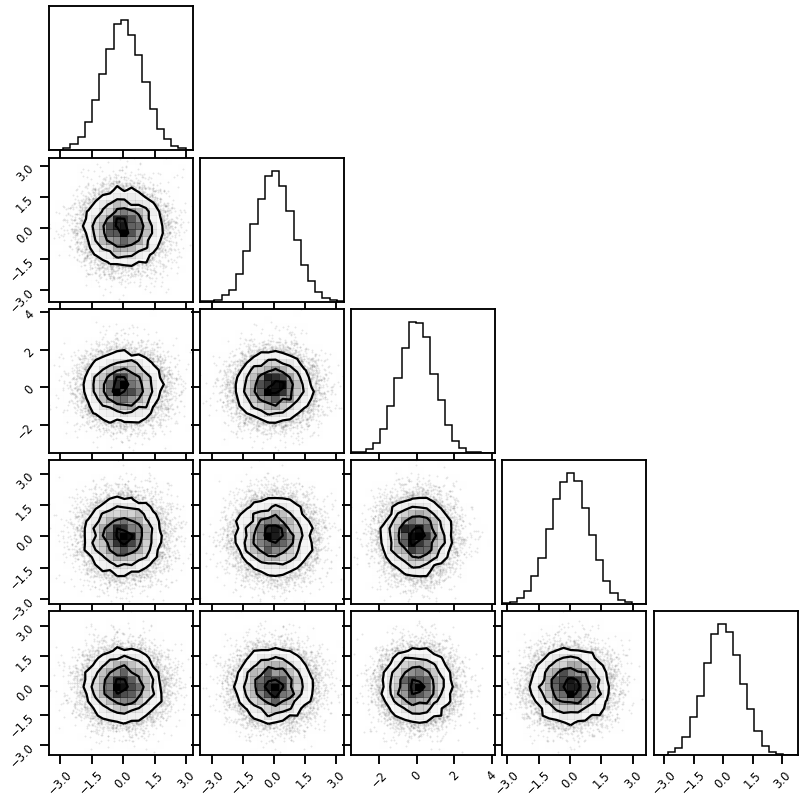

In [20]:
fig = corner.corner(X_g, hist_factor=2)

In [13]:
rbig_model.info_loss.sum()

DeviceArray(5.93331692, dtype=float64)

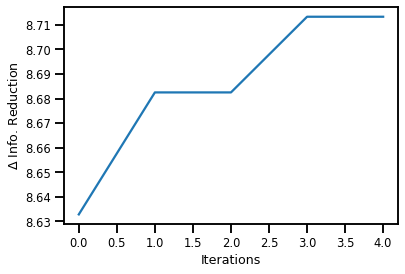

In [21]:
fig, ax = plt.subplots()
ax.plot(jnp.cumsum(rbig_model.info_loss))
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

In [12]:
%%time


X = np.array(data, dtype=np.float32)

tc = rbig_total_correlation(
    X=X.block_until_ready(),
    zero_tolerance=zero_tolerance,
    return_all=False
)
print(f"RBIG TC: {tc:.5f}")

RBIG TC: 34.75812
CPU times: user 16.8 s, sys: 7.33 s, total: 24.1 s
Wall time: 13.1 s
